In [ ]:
from google.colab import files
import zipfile
import os

#Télécharger un fichier ZIP depuis ton ordinateur
uploaded = files.upload()  # Une boîte de dialogue va s’ouvrir pour choisir le fichier

Saving archive.zip to archive.zip


In [ ]:
# Étape 3 : Trouver le nom du fichier ZIP
for filename in uploaded.keys():
    zip_filename = filename
    break

# Étape 4 : Définir le chemin de destination dans Google Drive
destination_folder = '/content/drive/MyDrive/data/'  # Tu peux changer le nom du dossier

# Créer le dossier s’il n’existe pas
os.makedirs(destination_folder, exist_ok=True)

# Étape 5 : Extraire le fichier ZIP dans Google Drive
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"✅ Le fichier a été extrait dans : {destination_folder}")

✅ Le fichier a été extrait dans : /content/drive/MyDrive/data/


Importation des bibliothèques nécessaires

In [ ]:
import os
import cv2
import numpy as np
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle


Prétraitement

In [ ]:
# Chemins des dossiers
train_path = "/content/drive/MyDrive/data/dataset/train"
no_tumor_path = os.path.join(train_path, "no_tumor")
tumor_path = os.path.join(train_path, "tumor")

# Paramètres
target_size = (224, 224)  # Taille cible pour le redimensionnement

Fonction de Prétraitement des Images IRM pour la Détection de Tumeurs Cérébrales

In [ ]:
def preprocess_image(image_path, target_size):
    """
    Fonction de pré-traitement d'une image IRM
    """
    # 1. Chargement de l'image
    img = cv2.imread(image_path)

    # 2. Conversion en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3. Égalisation de l'histogramme pour améliorer le contraste
    gray = exposure.equalize_adapthist(gray, clip_limit=0.03)
    gray = (gray * 255).astype(np.uint8)

    # 4. Seuillage automatique (Otsu)
    thresh = threshold_otsu(gray)
    binary = gray > thresh

    # 5. Nettoyage et remplissage des régions
    binary = clear_border(binary)
    binary = closing(binary, square(3))

    # 6. Détection des contours et recadrage
    label_img = label(binary)
    regions = regionprops(label_img)

    if regions:
        # Prendre la plus grande région (cerveau)
        largest_region = max(regions, key=lambda x: x.area)
        minr, minc, maxr, maxc = largest_region.bbox

        # Recadrage de l'image originale sur la région du cerveau
        cropped = gray[minr:maxr, minc:maxc]
    else:
        # Si aucune région n'est détectée, utiliser l'image entière
        cropped = gray

    # 7. Redimensionnement
    resized = cv2.resize(cropped, target_size)

    # 8. Normalisation [0-1]
    normalized = resized / 255.0

    return normalized

Chargement et Prétraitement des Données IRM (Avec et Sans Tumeur)

In [ ]:
def load_and_preprocess_data(folder_path, label, target_size):
    """
    Charge et pré-traite toutes les images d'un dossier
    """
    images = []
    labels = []

    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            try:
                # Pré-traitement
                processed_img = preprocess_image(image_path, target_size)
                images.append(processed_img)
                labels.append(label)
            except Exception as e:
                print(f"Erreur lors du traitement de {image_path}: {str(e)}")

    return np.array(images), np.array(labels)

# Chargement et pré-traitement des images sans tumeur
print("Traitement des images sans tumeur...")
no_tumor_images, no_tumor_labels = load_and_preprocess_data(no_tumor_path, 0, target_size)

# Chargement et pré-traitement des images avec tumeur
print("\nTraitement des images avec tumeur...")
tumor_images, tumor_labels = load_and_preprocess_data(tumor_path, 1, target_size)

# Fusion des données
print("\nFusion des données...")
X = np.concatenate((no_tumor_images, tumor_images), axis=0)
y = np.concatenate((no_tumor_labels, tumor_labels), axis=0)

# Mélange des données
X, y = shuffle(X, y, random_state=42)

# Ajout d'une dimension pour les canaux (nécessaire pour CNN)
X = np.expand_dims(X, axis=-1)


Traitement des images sans tumeur...


  0%|          | 0/1600 [00:00<?, ?it/s]<ipython-input-3-6b10a0786ef5>:21: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  binary = closing(binary, square(3))
100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]



Traitement des images avec tumeur...


100%|██████████| 4019/4019 [05:39<00:00, 11.85it/s]



Fusion des données...


In [ ]:
# Affichage des formes finales
print("\nPré-traitement terminé !")
print(f"Forme de X: {X.shape}")
print(f"Forme de y: {y.shape}")


Pré-traitement terminé !
Forme de X: (5619, 224, 224, 1)
Forme de y: (5619,)


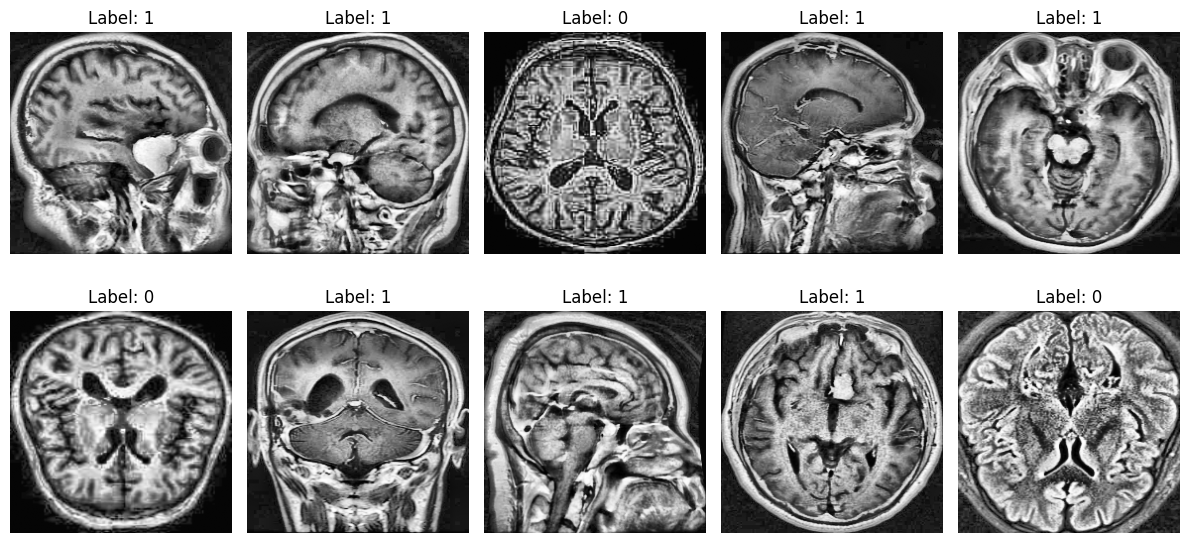

In [ ]:
# Visualisation de quelques images pré-traitées
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Visualisation du Résultat du Prétraitement sur une Image IRM

<ipython-input-3-6b10a0786ef5>:21: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  binary = closing(binary, square(3))


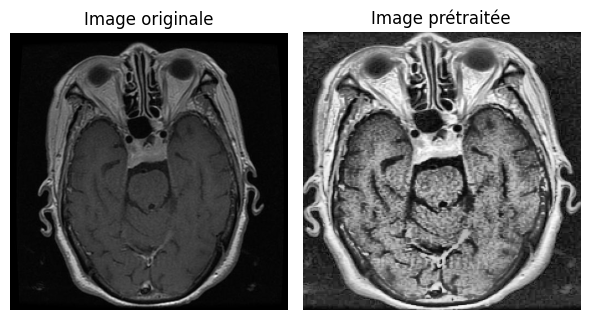

In [ ]:
# Sélectionner une image de test (par exemple la première image avec tumeur)
test_img_path = os.path.join(tumor_path, os.listdir(tumor_path)[0])

# Charger l'image originale
original_img = cv2.imread(test_img_path)
original_img_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

# Appliquer votre prétraitement
processed_img = preprocess_image(test_img_path, target_size)

# Afficher les deux images côte à côte
plt.figure(figsize=(6, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img_gray, cmap='gray')
plt.title('Image originale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_img.squeeze(), cmap='gray')  # .squeeze() pour enlever la dimension supplémentaire
plt.title('Image prétraitée')
plt.axis('off')

plt.tight_layout()
plt.show()

Sauvegarde des Données Prétraitées (Images IRM + Labels)

In [ ]:
import os
import numpy as np

# Chemin du dossier de sauvegarde
save_dir = '/content/drive/MyDrive/data/preprocessed'

# Créer le dossier s'il n'existe pas
os.makedirs(save_dir, exist_ok=True)

# Sauvegarder les données
np.save(os.path.join(save_dir, 'X_train.npy'), X)
np.save(os.path.join(save_dir, 'y_train.npy'), y)

print(f"Données sauvegardées dans {save_dir}")

Données sauvegardées dans /content/drive/MyDrive/data/preprocessed


Augmentation de données pour les images IRM de tumeurs cérébrales

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import os

# Charger les données pré-traitées
data_dir = '/content/drive/MyDrive/data/preprocessed'
X = np.load(os.path.join(data_dir, 'X_train.npy'))
y = np.load(os.path.join(data_dir, 'y_train.npy'))

# Vérification des formes
print(f"Forme initiale de X: {X.shape}")
print(f"Forme initiale de y: {y.shape}")

Forme initiale de X: (5619, 224, 224, 1)
Forme initiale de y: (5619,)


In [ ]:
# Nouveau paramètre cible (8000 images au lieu de 10000)
target_samples = 8000
current_samples = X.shape[0]

# Calcul du facteur d'augmentation ajusté
augmentation_factor = max(1, int(np.ceil(target_samples / current_samples)) - 1)

# Configuration de l'augmentation de données (plus conservatrice)
datagen = ImageDataGenerator(
    rotation_range=10,       # Réduit de 15 à 10 degrés
    width_shift_range=0.05,  # Réduit de 10% à 5%
    height_shift_range=0.05, # Réduit de 10% à 5%
    zoom_range=0.1,          # Réduit de 20% à 10%
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# Fonction optimisée pour augmenter les données par lots
def augment_data_batch(X, y, datagen, augmentation_factor, batch_size=256):
    augmented_images = []
    augmented_labels = []

    # Traiter par lots pour économiser la mémoire
    for start_idx in range(0, X.shape[0], batch_size):
        end_idx = min(start_idx + batch_size, X.shape[0])
        X_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]

        for i in range(X_batch.shape[0]):
            img = X_batch[i]
            label = y_batch[i]

            img = img.reshape((1,) + img.shape)
            aug_iter = datagen.flow(img, batch_size=1)

            for _ in range(augmentation_factor):
                augmented_img = next(aug_iter)[0]
                augmented_images.append(augmented_img)
                augmented_labels.append(label)

                # Arrêt prématuré si on atteint la cible
                if len(augmented_images) + X.shape[0] >= target_samples:
                    break
            if len(augmented_images) + X.shape[0] >= target_samples:
                break
        if len(augmented_images) + X.shape[0] >= target_samples:
            break

    return np.array(augmented_images), np.array(augmented_labels)

In [ ]:
 #Augmenter les données par lots
print("\nDébut de l'augmentation des données (version optimisée pour 8000 images)...")
X_aug, y_aug = augment_data_batch(X, y, datagen, augmentation_factor)


Début de l'augmentation des données (version optimisée pour 8000 images)...


In [ ]:
# Combiner les données
X_combined = np.concatenate((X, X_aug), axis=0)
y_combined = np.concatenate((y, y_aug), axis=0)

In [ ]:
# Ajustement final à 8000 images exactement
if X_combined.shape[0] > target_samples:
    indices = np.random.choice(X_combined.shape[0], target_samples, replace=False)
    X_combined = X_combined[indices]
    y_combined = y_combined[indices]

# Mélanger les données
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

In [ ]:
# Vérification des résultats
print("\nAugmentation terminée avec succès!")
print(f"Forme finale de X: {X_combined.shape}")
print(f"Forme finale de y: {y_combined.shape}")


Augmentation terminée avec succès!
Forme finale de X: (8000, 224, 224, 1)
Forme finale de y: (8000,)


In [ ]:
 #Distribution des classes
unique, counts = np.unique(y_combined, return_counts=True)
print("\nDistribution des classes:")
print(dict(zip(unique, counts)))


Distribution des classes:
{np.int64(0): np.int64(2315), np.int64(1): np.int64(5685)}


In [ ]:
 #Sauvegarde
save_dir = '/content/drive/MyDrive/data/augmented'
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, 'X_train_augmented.npy'), X_combined)
np.save(os.path.join(save_dir, 'y_train_augmented.npy'), y_combined)

print(f"\nDonnées augmentées (8000 images) sauvegardées dans {save_dir}")


Données augmentées (8000 images) sauvegardées dans /content/drive/MyDrive/data/augmented


visualiser les images augmentées sauvegardées

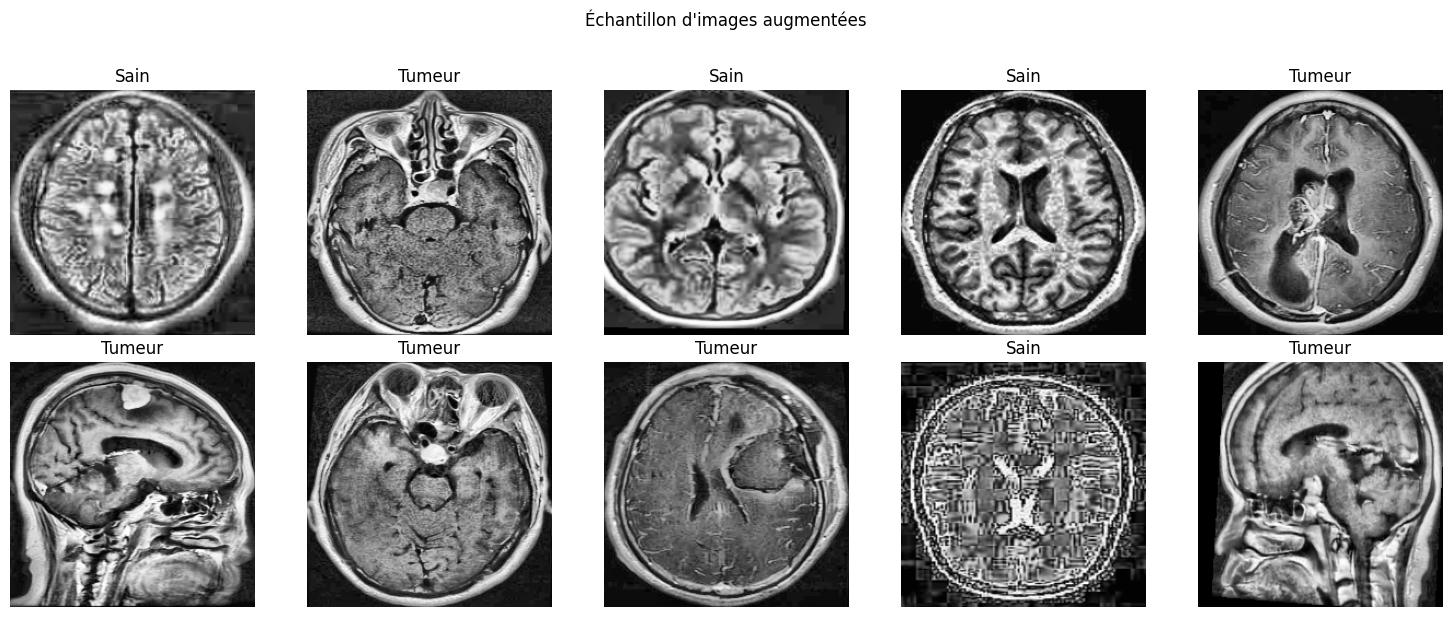

In [ ]:
# Charger les données augmentées
aug_dir = '/content/drive/MyDrive/data/augmented'
X_aug = np.load(os.path.join(aug_dir, 'X_train_augmented.npy'))
y_aug = np.load(os.path.join(aug_dir, 'y_train_augmented.npy'))

# Sélectionner aléatoirement quelques images à visualiser
num_samples = 10
indices = np.random.choice(range(len(X_aug)), num_samples, replace=False)

# Afficher les images
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_aug[idx].squeeze(), cmap='gray')
    plt.title("Tumeur" if y_aug[idx] == 1 else "Sain")
    plt.axis('off')

plt.suptitle("Échantillon d'images augmentées", y=1.02)
plt.tight_layout()
plt.show()

Division du Jeu de Données : Entraînement, Validation et Test

In [ ]:
import numpy as np

# Charger les données
X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')
y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')


In [ ]:
from sklearn.model_selection import train_test_split

# D'abord, diviser entre train et test (ex: 80% train, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Puis diviser X_temp en train et validation (ex: 80% de train -> 64%, 20% validation -> 16%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)


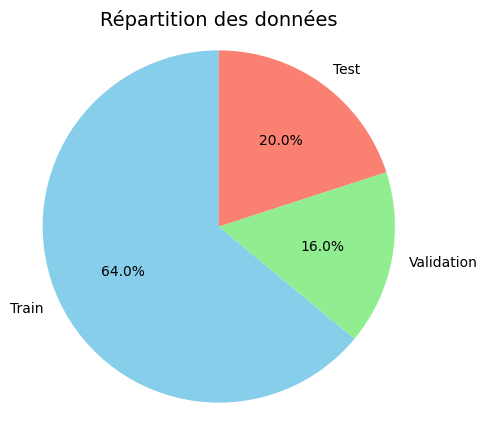

In [ ]:
import matplotlib.pyplot as plt

# Taille des jeux de données
sizes = [len(y_train), len(y_val), len(y_test)]
labels = ['Train', 'Validation', 'Test']
colors = ['skyblue', 'lightgreen', 'salmon']

# Création du camembert simple
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des données", fontsize=14)
plt.axis('equal')  # Pour un cercle parfait
plt.show()


Traitement des étiquettes : Encodage One-Hot (One-Hot Encoding)

In [ ]:
from tensorflow.keras.utils import to_categorical

# Encodage One-Hot
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

# Affichage pour vérification
print("Exemple d'encodage (1er élément):", y_train[0], "→", y_train_encoded[0])
print("Formes des nouvelles étiquettes :")
print("y_train_encoded :", y_train_encoded.shape)
print("y_val_encoded   :", y_val_encoded.shape)
print("y_test_encoded  :", y_test_encoded.shape)


Exemple d'encodage (1er élément): 1 → [0. 1.]
Formes des nouvelles étiquettes :
y_train_encoded : (3596, 2)
y_val_encoded   : (899, 2)
y_test_encoded  : (1124, 2)


Entraînement d’un modèle CNN pour la détection de tumeur

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Forme des entrées
input_shape = X_train.shape[1:]  # (hauteur, largeur, canaux)
num_classes = y_train_encoded.shape[1]

# Modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Callbacks utiles
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#  Entraînement
history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8330 - loss: 0.9809

113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.8334 - loss: 0.9766 - val_accuracy: 0.7152 - val_loss: 1.1961
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9541 - loss: 0.1255 - val_accuracy: 0.7152 - val_loss: 2.1481
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9781 - loss: 0.0675

113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9780 - loss: 0.0676 - val_accuracy: 0.7186 - val_loss: 0.7284
Epoch 4/30
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9790 - loss: 0.0543

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9790 - loss: 0.0543 - val_accuracy: 0.7297 - val_loss: 0.6999
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9829 - loss: 0.0530

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9830 - loss: 0.0529 - val_accuracy: 0.9210 - val_loss: 0.2218
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9891 - loss: 0.0286

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9891 - loss: 0.0286 - val_accuracy: 0.9700 - val_loss: 0.1163
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9887 - loss: 0.0266

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9887 - loss: 0.0266 - val_accuracy: 0.9677 - val_loss: 0.1046
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9912 - loss: 0.0278 - val_accuracy: 0.9622 - val_loss: 0.1178
Epoch 9/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9926 - loss: 0.0240 - val_accuracy: 0.9700 - val_loss: 0.1114
Epoch 10/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9888 - loss: 0.0319 - val_accuracy: 0.9666 - val_loss: 0.1555
Epoch 11/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9934 - loss: 0.0219 - val_accuracy: 0.9700 - val_loss: 0.1205
Epoch 12/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9949 - loss: 0.0145 - val_accuracy: 0.9711 - val_loss: 0.1290


In [ ]:
# Évaluation sur les données de test
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f" Précision sur le jeu de test : {accuracy * 100:.2f}%")


 Précision sur le jeu de test : 96.44%


In [ ]:
# Dossier où tu veux enregistrer le modèle dans ton Drive
model_path = '/content/drive/MyDrive//data/CNN_model.h5'
model.save(model_path)
print(f" Modèle sauvegardé avec succès ici : {model_path}")

 Modèle sauvegardé avec succès ici : /content/drive/MyDrive//data/CNN_model.h5


Visualisation des courbes d'entraînement, matrice de confusion et rapport de classification

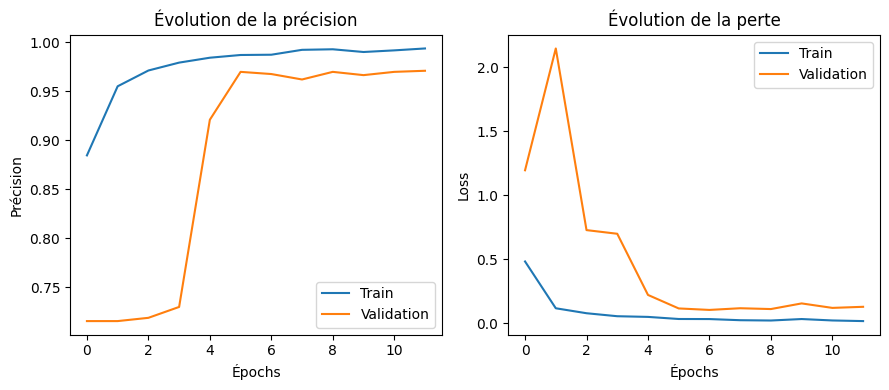

In [ ]:
import matplotlib.pyplot as plt

# Précision
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Évolution de la précision")
plt.xlabel("Épochs")
plt.ylabel("Précision")
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Évolution de la perte")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


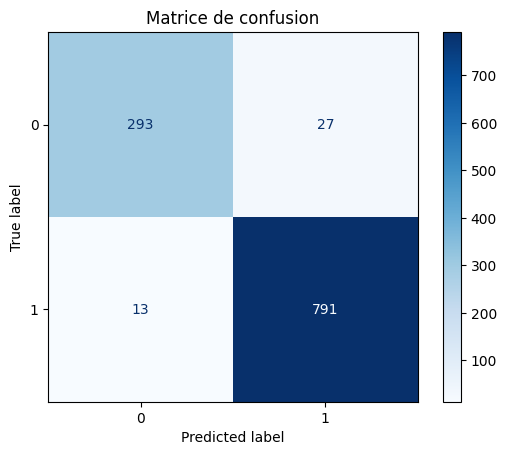

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Prédictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matrice de confusion")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print("📄 Rapport de classification :\n")
print(report)


📄 Rapport de classification :

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       320
           1       0.97      0.98      0.98       804

    accuracy                           0.96      1124
   macro avg       0.96      0.95      0.96      1124
weighted avg       0.96      0.96      0.96      1124



Visualisation des courbes ROC et calcul de l'AUC pour chaque classe

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


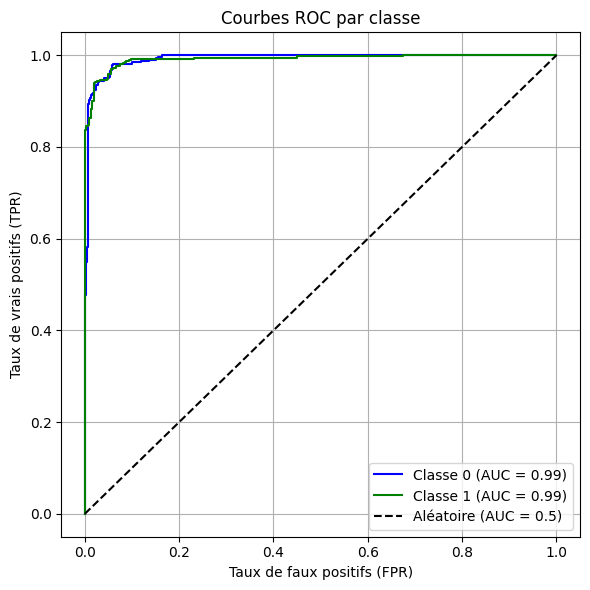

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Étape 1 : Binarisation des classes vraies
n_classes = y_test_encoded.shape[1]  # nombre de classes

# Étape 2 : Prédictions probabilistes
y_score = model.predict(X_test)

# Étape 3 : Calcul ROC et AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Étape 4 : Tracer les courbes ROC
plt.figure(figsize=(6, 6))
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

# Courbe aléatoire
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbes ROC par classe')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Évaluer les performances globales (précision + perte)


In [ ]:
# Évaluation du modèle sur le jeu de test
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f" Précision sur le jeu de test : {accuracy * 100:.2f}%")
print(f" Perte (loss) sur le jeu de test : {loss:.4f}")


 Précision sur le jeu de test : 96.44%
 Perte (loss) sur le jeu de test : 0.1209


Afficher quelques prédictions visuelles (images + vrai vs prédit)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


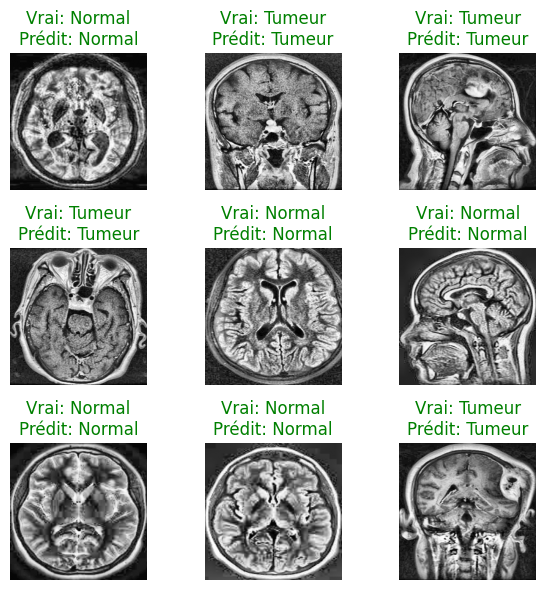

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prédire les classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# (optionnel) noms de classes
class_names = ['Normal', 'Tumeur']  # adapter selon tes données

# Afficher 9 exemples avec leurs prédictions
plt.figure(figsize=(6, 6))
for i in range(9):
    idx = np.random.randint(len(X_test))
    plt.subplot(3, 3, i + 1)
    image = X_test[idx].squeeze()  # pour enlever la dimension du canal si c’est (128,128,1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Vrai: {class_names[y_true[idx]]}\nPrédit: {class_names[y_pred[idx]]}",
              color='green' if y_true[idx] == y_pred[idx] else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()


Implémentation de ResNet50 pour la classification d’IRM


Les images doivent être redimensionnées à 224x224 (taille requise par ResNet50) avec 3 canaux (RGB).

Prétraitement des images (224x224 RGB + normalisation)



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import psutil
import gc
import os

# Configuration initiale
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Réduit les logs TensorFlow
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Fonction de nettoyage mémoire
def clear_memory():
    K.clear_session()
    gc.collect()

clear_memory()

# 1. Chargement des données
try:
    X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')
    y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')
    print("Données chargées avec succès")
except Exception as e:
    print(f"Erreur de chargement : {e}")
    raise

# 2. Division des données (version réduite pour debug si nécessaire)
DEBUG_MODE = False  # Mettre à True pour tester avec moins de données
if DEBUG_MODE:
    X = X[:1000]
    y = y[:1000]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# 3. Prétraitement adapté à ResNet50
def prepare_resnet_data(images):
    # Redimensionnement si nécessaire
    if images.shape[1:3] != (224, 224):
        resizing_layer = Resizing(224, 224)
        images = resizing_layer(images)

    # Conversion des niveaux de gris en RGB si nécessaire
    if images.shape[-1] == 1:
        images = np.repeat(images, 3, axis=-1)

    return preprocess_input(images.astype('float32'))

X_train_prep = prepare_resnet_data(X_train)
X_val_prep = prepare_resnet_data(X_val)
X_test_prep = prepare_resnet_data(X_test)

# Encodage One-Hot
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

# 4. Calcul automatique de la batch size
def get_optimal_batch_size():
    available_ram = psutil.virtual_memory().available / (1024**3)  # RAM en GB
    if available_ram > 12:  # Colab Pro
        return 32
    elif available_ram > 8:  # Colab standard
        return 16
    else:  # RAM limitée
        return 8

BATCH_SIZE = get_optimal_batch_size()
print(f"Batch size sélectionné : {BATCH_SIZE}")

# 5. Augmentation de données (version light)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0  # Valeur constante pour les zones vides
)

train_generator = train_datagen.flow(
    X_train_prep,
    y_train_encoded,
    batch_size=BATCH_SIZE
)

# 6. Construction du modèle optimisé
def build_light_resnet():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'  # Plus léger que GlobalAveragePooling
    )

    x = Dropout(0.4)(base_model.output)
    predictions = Dense(
        y_train_encoded.shape[1],
        activation='softmax',
        dtype='float32'  # Important pour mixed precision
    )(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Gel des couches de base
    for layer in base_model.layers:
        layer.trainable = False

    return model

model = build_light_resnet()

# 7. Compilation avec optimisation
optimizer = Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Callbacks améliorés
callbacks = [
    ModelCheckpoint(
        'best_model_weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,  # Plus léger
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# 9. Entraînement avec gestion d'erreurs
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=max(1, len(X_train_prep)//BATCH_SIZE),  # Évite division par zéro
        epochs=30,
        validation_data=(X_val_prep, y_val_encoded),
        callbacks=callbacks,
        verbose=1
    )
except Exception as e:
    print(f"Erreur pendant l'entraînement : {e}")
    print("Tentative de reprise avec des paramètres réduits...")

    # Réduction des paramètres
    BATCH_SIZE = max(4, BATCH_SIZE//2)
    train_generator.batch_size = BATCH_SIZE

    model = build_light_resnet()
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=max(1, len(X_train_prep)//BATCH_SIZE),
        epochs=15,
        validation_data=(X_val_prep[:len(X_val_prep)//2], y_val_encoded[:len(y_val_encoded)//2]),
        callbacks=callbacks,
        verbose=1
    )

# 10. Évaluation finale
try:
    test_loss, test_acc = model.evaluate(X_test_prep, y_test_encoded, batch_size=BATCH_SIZE)
    print(f"\nPerformance finale sur le test set : Accuracy = {test_acc:.4f}, Loss = {test_loss:.4f}")
except:
    print("\nÉvaluation sur un sous-ensemble de test...")
    test_loss, test_acc = model.evaluate(X_test_prep[:100], y_test_encoded[:100], batch_size=BATCH_SIZE)
    print(f"Accuracy (sur 100 échantillons) : {test_acc:.4f}")

# 11. Visualisation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history.get('accuracy', []), label='Train')
plt.plot(history.history.get('val_accuracy', []), label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history.get('loss', []), label='Train')
plt.plot(history.history.get('val_loss', []), label='Validation')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Nettoyage final
clear_memory()

Données chargées avec succès


ResNet101

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import gc

# Chargement allégé pour tester
X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')[:2000]
y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')[:2000]

# Conversion en float32 et RGB
X = np.repeat(X, 3, axis=-1).astype(np.float32)

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print shape
print("Train :", X_train.shape)
print("Validation :", X_val.shape)
print("Test :", X_test.shape)

# Clean memory
gc.collect()


Train : (1400, 224, 224, 3)
Validation : (300, 224, 224, 3)
Test : (300, 224, 224, 3)


22

Préparation des générateurs avec ImageDataGenerator

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation pour le training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Pas d'augmentation pour validation / test
val_test_datagen = ImageDataGenerator()

# Générateurs
train_gen = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_gen = val_test_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_gen = val_test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)


Définition du modèle ResNet101

In [3]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Charger le modèle sans la tête
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # On freeze la base pour commencer

# Ajouter une tête personnalisée
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Modèle complet
model = Model(inputs=base_model.input, outputs=output)

# Compilation
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 42,920,577 (163.73 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

Entraînement avec callbacks

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/models/best_model.h5', save_best_only=True)
]

# Entraînement
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5900 - loss: 0.7367

44/44 ━━━━━━━━━━━━━━━━━━━━ 68s 933ms/step - accuracy: 0.5906 - loss: 0.7361 - val_accuracy: 0.6967 - val_loss: 0.5965
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6161 - loss: 0.7125

44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.6165 - loss: 0.7118 - val_accuracy: 0.6967 - val_loss: 0.5770
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7011 - loss: 0.6123

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 467ms/step - accuracy: 0.7008 - loss: 0.6127 - val_accuracy: 0.6967 - val_loss: 0.5580
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6572 - loss: 0.6449

44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 490ms/step - accuracy: 0.6576 - loss: 0.6445 - val_accuracy: 0.7033 - val_loss: 0.5473
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7108 - loss: 0.5874

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - accuracy: 0.7104 - loss: 0.5877 - val_accuracy: 0.7233 - val_loss: 0.5374
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7137 - loss: 0.5922

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 463ms/step - accuracy: 0.7137 - loss: 0.5922 - val_accuracy: 0.7500 - val_loss: 0.5284
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 419ms/step - accuracy: 0.6762 - loss: 0.6129 - val_accuracy: 0.7233 - val_loss: 0.5300
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7210 - loss: 0.5676

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 466ms/step - accuracy: 0.7211 - loss: 0.5674 - val_accuracy: 0.7567 - val_loss: 0.5157
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7525 - loss: 0.5327

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - accuracy: 0.7523 - loss: 0.5330 - val_accuracy: 0.7733 - val_loss: 0.5079
Epoch 10/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7502 - loss: 0.5425

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 477ms/step - accuracy: 0.7499 - loss: 0.5430 - val_accuracy: 0.7800 - val_loss: 0.5027
Epoch 11/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7320 - loss: 0.5637

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - accuracy: 0.7323 - loss: 0.5633 - val_accuracy: 0.7767 - val_loss: 0.4996
Epoch 12/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7517 - loss: 0.5433

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - accuracy: 0.7517 - loss: 0.5433 - val_accuracy: 0.7933 - val_loss: 0.4928
Epoch 13/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7519 - loss: 0.5380

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - accuracy: 0.7518 - loss: 0.5382 - val_accuracy: 0.7800 - val_loss: 0.4915
Epoch 14/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.7386 - loss: 0.5551

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 479ms/step - accuracy: 0.7389 - loss: 0.5549 - val_accuracy: 0.7900 - val_loss: 0.4856
Epoch 15/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7594 - loss: 0.5319

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.7593 - loss: 0.5318 - val_accuracy: 0.7900 - val_loss: 0.4811
Epoch 16/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7393 - loss: 0.5426

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 484ms/step - accuracy: 0.7396 - loss: 0.5423 - val_accuracy: 0.7933 - val_loss: 0.4770
Epoch 17/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7773 - loss: 0.5191

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - accuracy: 0.7772 - loss: 0.5191 - val_accuracy: 0.8000 - val_loss: 0.4725
Epoch 18/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7860 - loss: 0.4929

44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 483ms/step - accuracy: 0.7857 - loss: 0.4934 - val_accuracy: 0.8167 - val_loss: 0.4680
Epoch 19/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 423ms/step - accuracy: 0.7462 - loss: 0.5301 - val_accuracy: 0.7900 - val_loss: 0.4689
Epoch 20/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7524 - loss: 0.5178

44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 492ms/step - accuracy: 0.7524 - loss: 0.5179 - val_accuracy: 0.8200 - val_loss: 0.4630
Epoch 21/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7658 - loss: 0.5276

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - accuracy: 0.7660 - loss: 0.5273 - val_accuracy: 0.8067 - val_loss: 0.4615
Epoch 22/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7746 - loss: 0.5109

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - accuracy: 0.7747 - loss: 0.5107 - val_accuracy: 0.8133 - val_loss: 0.4556
Epoch 23/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7743 - loss: 0.5262

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.7743 - loss: 0.5258 - val_accuracy: 0.8167 - val_loss: 0.4528
Epoch 24/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.7853 - loss: 0.5090

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.7852 - loss: 0.5090 - val_accuracy: 0.8133 - val_loss: 0.4511
Epoch 25/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8061 - loss: 0.4804

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 478ms/step - accuracy: 0.8058 - loss: 0.4807 - val_accuracy: 0.8200 - val_loss: 0.4450
Epoch 26/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7791 - loss: 0.4990

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.7792 - loss: 0.4990 - val_accuracy: 0.8267 - val_loss: 0.4424
Epoch 27/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7638 - loss: 0.4944

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 484ms/step - accuracy: 0.7641 - loss: 0.4944 - val_accuracy: 0.8300 - val_loss: 0.4383
Epoch 28/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.7811 - loss: 0.4859

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.7811 - loss: 0.4861 - val_accuracy: 0.8233 - val_loss: 0.4379
Epoch 29/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8008 - loss: 0.4682

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - accuracy: 0.8004 - loss: 0.4687 - val_accuracy: 0.8300 - val_loss: 0.4343
Epoch 30/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7871 - loss: 0.4943

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - accuracy: 0.7870 - loss: 0.4940 - val_accuracy: 0.8267 - val_loss: 0.4311


Évaluation finale

In [5]:
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8098 - loss: 0.4347
Test Accuracy: 0.8133


Visualisation des courbes d’entraînement

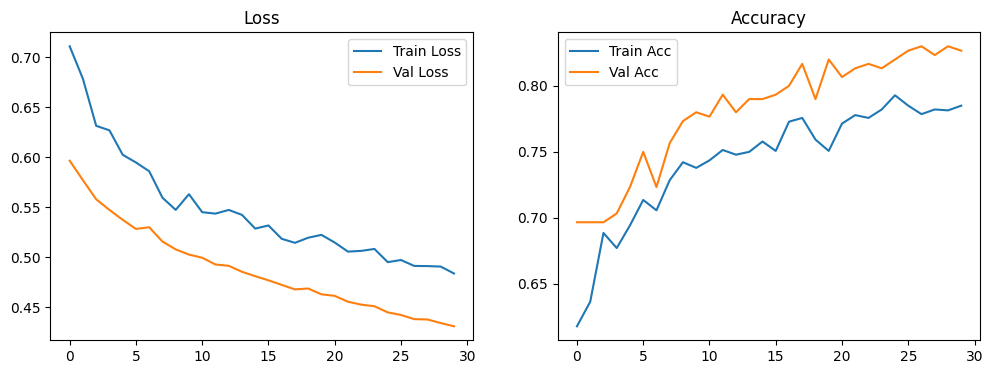

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()


Rapport de classification + Matrice de confusion

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1. Prédictions sur le jeu de test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 2. Rapport de classification
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Sans tumeur", "Avec tumeur"]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
Classification Report:

              precision    recall  f1-score   support

 Sans tumeur       0.81      0.49      0.61        90
 Avec tumeur       0.81      0.95      0.88       210

    accuracy                           0.81       300
   macro avg       0.81      0.72      0.74       300
weighted avg       0.81      0.81      0.80       300



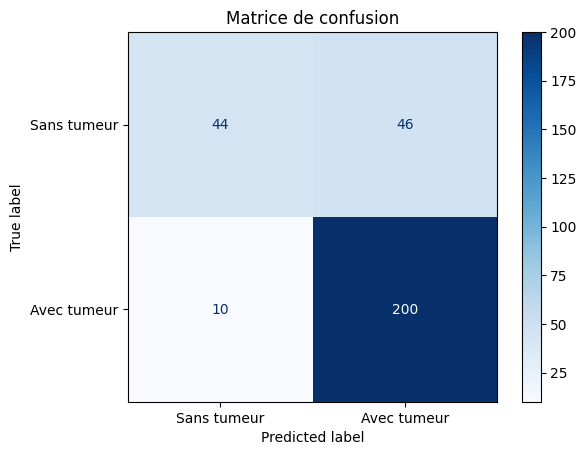

In [8]:
# 3. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sans tumeur", "Avec tumeur"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

EfficientNetB0

Importer les bibliothèques nécessaires

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


Charger les données

In [2]:
X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')
y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')


Diviser les données en train, validation et test

In [3]:
# 60% train, 20% val, 20% test par exemple

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (3371, 224, 224, 1), Validation shape: (1124, 224, 224, 1), Test shape: (1124, 224, 224, 1)


Data augmentation (pour le train uniquement)

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  # juste normalisation si besoin


normaliser les images selon EfficientNet

In [5]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess_fn(x):
    return preprocess_input(x)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


Construire le modèle EfficientNetB0

In [6]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # On freeze la base au départ

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # binaire

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Callbacks pour éviter overfitting

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)


Entraîner le modèle

In [8]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 75s 457ms/step - accuracy: 0.6789 - loss: 0.6341 - val_accuracy: 0.7153 - val_loss: 0.5960 - learning_rate: 1.0000e-04
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.7081 - loss: 0.6178 - val_accuracy: 0.7153 - val_loss: 0.5960 - learning_rate: 1.0000e-04
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.7135 - loss: 0.6081 - val_accuracy: 0.7153 - val_loss: 0.5998 - learning_rate: 1.0000e-04
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.7234 - loss: 0.5977 - val_accuracy: 0.7153 - val_loss: 0.5961 - learning_rate: 1.0000e-04
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.7132 - loss: 0.6019 - val_accuracy: 0.7153 - val_loss: 0.5950 - learning_rate: 1.0000e-04
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.7123 - loss: 0.5995 - val_accuracy: 0.7153 - val_loss: 0.5937 - learning_rate: 1.0000e-04
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 14

Débloquer quelques couches du modèle (fine-tuning)

In [9]:
base_model.trainable = True

# On gèle les premières couches (par exemple 75%)
fine_tune_at = int(len(base_model.layers) * 0.75)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 76s 380ms/step - accuracy: 0.5029 - loss: 0.7561 - val_accuracy: 0.7153 - val_loss: 0.6096 - learning_rate: 1.0000e-05
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.6934 - loss: 0.6034 - val_accuracy: 0.7153 - val_loss: 0.5963 - learning_rate: 1.0000e-05
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.7424 - loss: 0.5582 - val_accuracy: 0.7153 - val_loss: 0.5778 - learning_rate: 1.0000e-05
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.7349 - loss: 0.5523 - val_accuracy: 0.7491 - val_loss: 0.5823 - learning_rate: 1.0000e-05
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.7406 - loss: 0.5478 - val_accuracy: 0.8194 - val_loss: 0.5158 - learning_rate: 1.0000e-05
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.7476 - loss: 0.5253 - val_accuracy: 0.8078 - val_loss: 0.4856 - learning_rate: 1.0000e-05
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 14

Évaluation finale sur le test set

36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step
Classification Report:
               precision    recall  f1-score   support

 Sans tumeur       0.83      0.57      0.67       320
 Avec tumeur       0.85      0.96      0.90       804

    accuracy                           0.84      1124
   macro avg       0.84      0.76      0.79      1124
weighted avg       0.84      0.84      0.83      1124



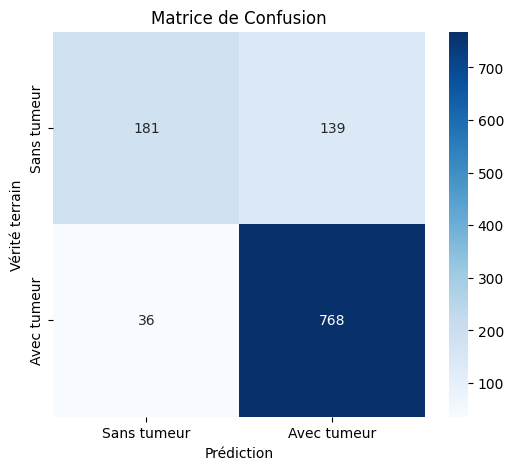

In [10]:
# Prétraiter le test set
X_test_pp = preprocess_input(X_test)

# Prédictions
y_pred_prob = model.predict(X_test_pp)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Rapport classification et matrice confusion
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Sans tumeur', 'Avec tumeur']))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sans tumeur', 'Avec tumeur'], yticklabels=['Sans tumeur', 'Avec tumeur'])
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de Confusion')
plt.show()


In [11]:
import matplotlib.pyplot as plt

# Afficher l'accuracy finale sur train et validation
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train Accuracy finale : {train_acc:.4f}")
print(f"Validation Accuracy finale : {val_acc:.4f}")

Train Accuracy finale : 0.7152
Validation Accuracy finale : 0.7153


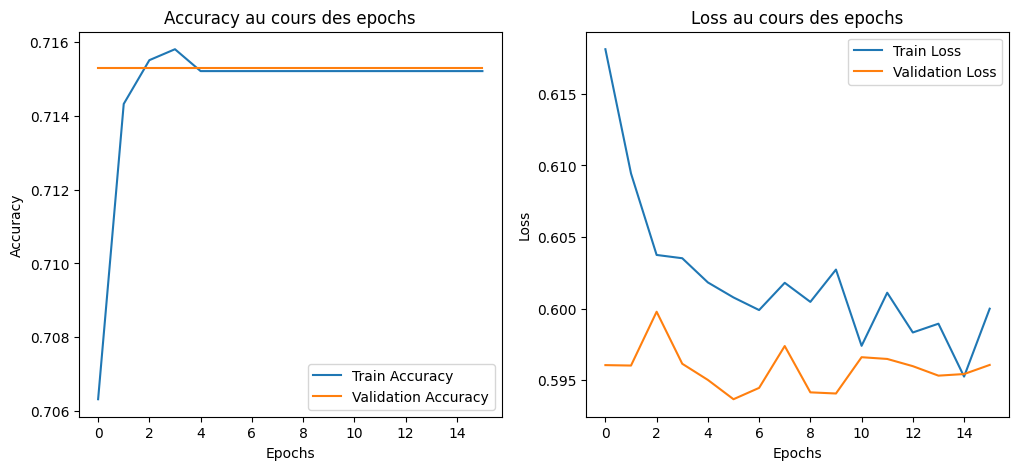

In [12]:
# Visualisation des courbes d'accuracy et de loss
def plot_training_curves(history):
    # Accuracy
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy au cours des epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss au cours des epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Appel de la fonction
plot_training_curves(history)